# **Basic Graph Neural Network with Edge Prediction on MNIST**

## **Libraries**

In [1]:
from torch.utils.data.dataset import Subset
from scipy.spatial.distance import cdist
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import datasets
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.nn as nn
import numpy as np
import torch
import time

In [2]:
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

## **Settings**

In [3]:
DEVICE = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

In [4]:
RANDOM_SEED = 1
LEARNING_RATE = 0.0005
NUM_EPOCHS = 10
BATCH_SIZE = 128
IMG_SIZE = 28

In [5]:
NUM_CLASSES = 10

## **MNIST Dataset**

In [6]:
train_indices = torch.arange(0, 59000)
valid_indices = torch.arange(59000, 60000)

In [7]:
custom_transform = transforms.Compose([transforms.ToTensor()])

In [8]:
train_and_valid = datasets.MNIST(root='data', train=True, transform=custom_transform, download=True)
test_dataset = datasets.MNIST(root='data', train=False, transform=custom_transform, download=True)

In [9]:
train_dataset = Subset(train_and_valid, train_indices)
valid_dataset = Subset(train_and_valid, valid_indices)

In [10]:
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, num_workers=4, shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=BATCH_SIZE, num_workers=4, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, num_workers=4, shuffle=False)

In [11]:
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([128, 1, 28, 28])
Image label dimensions: torch.Size([128])


## **Model**

In [12]:
def make_coordinate_array(img_size, out_size=4):
    n_rows = img_size * img_size
    col, row = np.meshgrid(np.arange(img_size), np.arange(img_size))
    coord = np.stack((col, row), axis=2).reshape(-1, 2)
    coord = (coord - np.mean(coord, axis=0)) / (np.std(coord, axis=0) + 1e-5)
    coord = torch.from_numpy(coord).float()
    coord = torch.cat((coord.unsqueeze(0).repeat(n_rows, 1,  int(out_size/2-1)), coord.unsqueeze(1).repeat(1, n_rows, 1)), dim=2)
    return coord

In [13]:
class GraphNet(nn.Module):
    def __init__(self, img_size=28, coord_features=4, num_classes=10):
        super(GraphNet, self).__init__()
        
        n_rows = img_size**2
        self.fc = nn.Linear(n_rows, num_classes, bias=False)

        coord = make_coordinate_array(img_size, coord_features)
        self.register_buffer('coord', coord)
        self.pred_edge_fc = nn.Sequential(nn.Linear(coord_features, 32), nn.ReLU(), nn.Linear(32, 1), nn.Tanh())

    def forward(self, x):
        B = x.size(0)
        self.A = self.pred_edge_fc(self.coord).squeeze()
        A_tensor = self.A.unsqueeze(0)
        A_tensor = self.A.expand(B, -1, -1)
        x_reshape = x.view(B, -1, 1)
        avg_neighbor_features = (torch.bmm(A_tensor, x_reshape).view(B, -1))

        logits = self.fc(avg_neighbor_features)
        probas = F.softmax(logits, dim=1)
        return logits, probas

In [14]:
torch.manual_seed(RANDOM_SEED)
model = GraphNet(img_size=IMG_SIZE, num_classes=NUM_CLASSES)

In [15]:
model = model.to(DEVICE)

In [16]:
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)  

## **Training phase**

In [17]:
def compute_acc(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    for features, targets in data_loader:
        features = features.to(device)
        targets = targets.to(device)
        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100

In [18]:
start_time = time.time()

cost_list = []
train_acc_list, valid_acc_list = [], []


for epoch in range(NUM_EPOCHS):
    
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)
            
        logits, probas = model(features)
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        
        cost.backward()
        optimizer.step()
        
        cost_list.append(cost.item())
        if not batch_idx % 150:
            print (f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} | '
                   f'Batch {batch_idx:03d}/{len(train_loader):03d} |' 
                   f' Cost: {cost:.4f}')

    model.eval()
    with torch.set_grad_enabled(False): 
        
        train_acc = compute_acc(model, train_loader, device=DEVICE)
        valid_acc = compute_acc(model, valid_loader, device=DEVICE)
        
        print(f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d}\n'
              f'Train ACC: {train_acc:.2f} | Validation ACC: {valid_acc:.2f}')
        
        train_acc_list.append(train_acc)
        valid_acc_list.append(valid_acc)
        
    elapsed = (time.time() - start_time)/60
    print(f'Time elapsed: {elapsed:.2f} min')
  
elapsed = (time.time() - start_time)/60

Epoch: 001/010 | Batch 000/461 | Cost: 28.7652
Epoch: 001/010 | Batch 150/461 | Cost: 2.1801
Epoch: 001/010 | Batch 300/461 | Cost: 1.8386
Epoch: 001/010 | Batch 450/461 | Cost: 1.7332
Epoch: 001/010
Train ACC: 47.18 | Validation ACC: 43.70
Time elapsed: 4.35 min
Epoch: 002/010 | Batch 000/461 | Cost: 1.6106
Epoch: 002/010 | Batch 150/461 | Cost: 1.4246
Epoch: 002/010 | Batch 300/461 | Cost: 1.2994
Epoch: 002/010 | Batch 450/461 | Cost: 1.0851
Epoch: 002/010
Train ACC: 67.54 | Validation ACC: 73.20
Time elapsed: 8.90 min
Epoch: 003/010 | Batch 000/461 | Cost: 1.0875
Epoch: 003/010 | Batch 150/461 | Cost: 0.9226
Epoch: 003/010 | Batch 300/461 | Cost: 1.1363
Epoch: 003/010 | Batch 450/461 | Cost: 0.9617
Epoch: 003/010
Train ACC: 68.64 | Validation ACC: 73.90
Time elapsed: 13.49 min
Epoch: 004/010 | Batch 000/461 | Cost: 0.9415
Epoch: 004/010 | Batch 150/461 | Cost: 0.9627
Epoch: 004/010 | Batch 300/461 | Cost: 0.8996
Epoch: 004/010 | Batch 450/461 | Cost: 0.8536
Epoch: 004/010
Train ACC:

In [19]:
print(f'Total Training Time: {elapsed:.2f} min')

Total Training Time: 44.94 min


## **Evaluation**

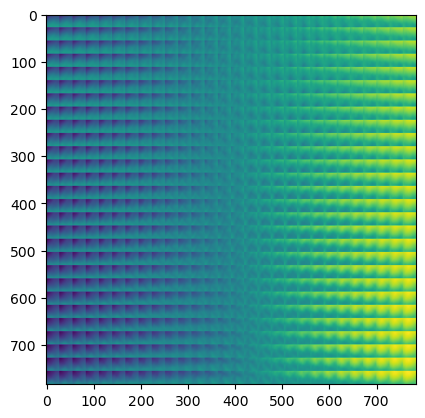

In [20]:
plt.imshow(model.A.to('cpu'));

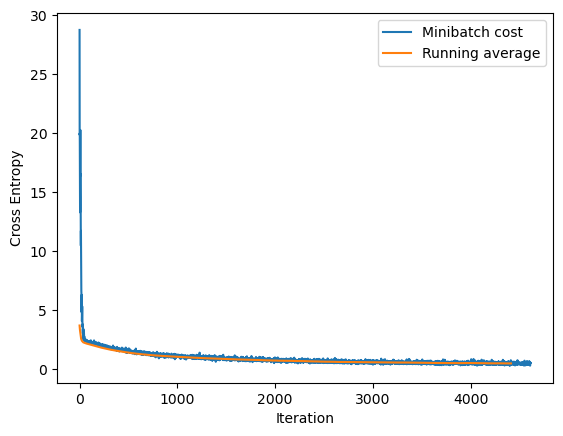

In [21]:
plt.plot(cost_list, label='Minibatch cost')
plt.plot(np.convolve(cost_list, np.ones(200,)/200, mode='valid'), label='Running average')

plt.ylabel('Cross Entropy')
plt.xlabel('Iteration')
plt.legend()
plt.show()

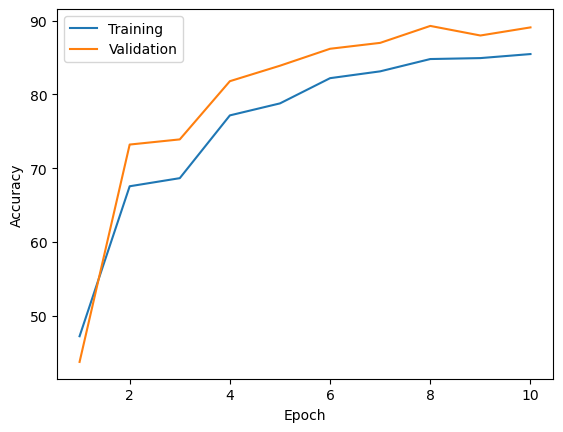

In [22]:
plt.plot(np.arange(1, NUM_EPOCHS+1), train_acc_list, label='Training')
plt.plot(np.arange(1, NUM_EPOCHS+1), valid_acc_list, label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [23]:
with torch.set_grad_enabled(False):
    test_acc = compute_acc(model=model,
                           data_loader=test_loader,
                           device=DEVICE)
    
    valid_acc = compute_acc(model=model,
                            data_loader=valid_loader,
                            device=DEVICE)
    

print(f'Validation ACC: {valid_acc:.2f}%')
print(f'Test ACC: {test_acc:.2f}%')

Validation ACC: 89.10%
Test ACC: 86.47%
